In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import os
from source.data_processing.image_reading import read_image
from source.data_processing.transformations import sample_random_affine_matrix
from typing import Tuple, List
from torchvision import transforms
from kornia.geometry.transform import warp_affine
from matplotlib import pyplot as plt
from source.visualization.image_visualization import (
    plot_images_with_matches_via_mapping,
    plot_images_with_matches_via_match_matrix,
)
from source.data_processing.keypoints import generate_image_grid_coordinates
from source.data_processing.transformations import *
from source.visualization.image_visualization import plot_image_with_crop

In [2]:
# class BrainDataset(Dataset):
#     def __init__(
#         self,
#         images_directory: str,
#         train: bool,
#         transform: transforms.transforms.Compose,
#     ) -> None:
#         super().__init__()
#         self.train = train
#         self.image_names = self._get_image_names(images_directory=images_directory)
#         self.images_directory = images_directory
#         self.transform = transform

#     def __len__(self) -> int:
#         """
#         Return the number of images in the dataset -1, since this dataset works with pairs of images.
#         """
#         return len(self.image_names[:-1])

#     def _get_image_names(self, images_directory: str) -> List[str]:
#         """
#         Load image names from the directory based on training or testing phase.

#         Args:
#             images_directory (str): Directory path containing images.

#         Returns:
#             List[str]: A list of image file names.
#         """
#         image_files = os.listdir(images_directory)
#         return image_files[:-2] if self.train else image_files[-2:]

#     def _get_images(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         Load a pair of images from the dataset.

#         Args:
#             index (int): Index of the pair of images.

#         Returns:
#             Tuple[torch.Tensor, torch.Tensor]: A tuple containing the images.
#         """
#         image_1 = read_image(
#             os.path.join(self.images_directory, self.image_names[index])
#         )
#         image_2 = read_image(
#             os.path.join(self.images_directory, self.image_names[index + 1])
#         )

#         image_1 = transforms.ToTensor()(image_1)
#         image_2 = transforms.ToTensor()(image_2)

#         return image_1, image_2

#     def __getitem__(self, index: int):
#         # Read whole image
#         image_1, image_2 = self._get_images(index=index)

#         if self.transform:
#             image_1 = self.transform(image_1)
#             image_2 = self.transform(image_2)

#         transformation_matrix = sample_random_affine_matrix(
#             self.transformation_threshold
#         ).to(self.device)
#         image_2_transformed = warp_affine(image_2, transformation_matrix)

In [3]:
images_directory = "data/cyto_downscaled_3344_3904/"
image_names = os.listdir(images_directory)
image_1, image_2 = read_image(
    os.path.join(images_directory, image_names[0])
), read_image(os.path.join(images_directory, image_names[1]))
image_1 = transforms.ToTensor()(image_1)
image_2 = transforms.ToTensor()(image_2)

In [4]:
image_size = image_1.shape[-2:]

In [5]:
image_2.shape

torch.Size([1, 3344, 3904])

In [6]:
transformation_matrix = sample_random_affine_matrix(range_limit=0.3)
image_2 = warp_affine(
    src=image_2.unsqueeze(0), M=transformation_matrix, dsize=image_size, mode="nearest"
)[0]

In [7]:
image_2.shape

torch.Size([1, 3344, 3904])

In [7]:
grid_coordinates = generate_image_grid_coordinates(image_size)

In [8]:
transformation_matrix.shape

torch.Size([1, 2, 3])

In [9]:
image_coordinate_mapping = transform_grid_coordinates(
    grid_coordinates, transformation_matrix[0]
)

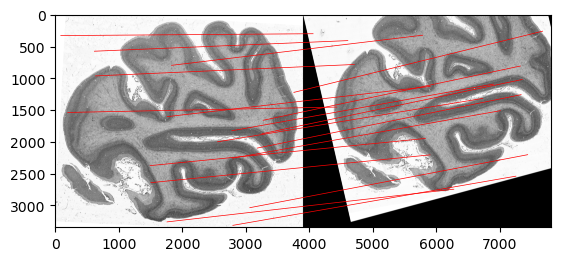

In [10]:
plot_images_with_matches_via_mapping(
    image_1,
    image_2,
    image_coordinate_mapping,
    number_of_matches=20,
    sample_keypoints_randomly=True,
)

In [11]:
from source.data_processing.cropping import sample_crop_coordinates, crop_image

In [12]:
crop_size = 640
max_translation_shift = 50

crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
    coordinate_mapping=image_coordinate_mapping,
    crop_size=crop_size,
    max_translation_shift=max_translation_shift,
)

In [49]:
image_2_crop.shape

torch.Size([1, 640, 640])

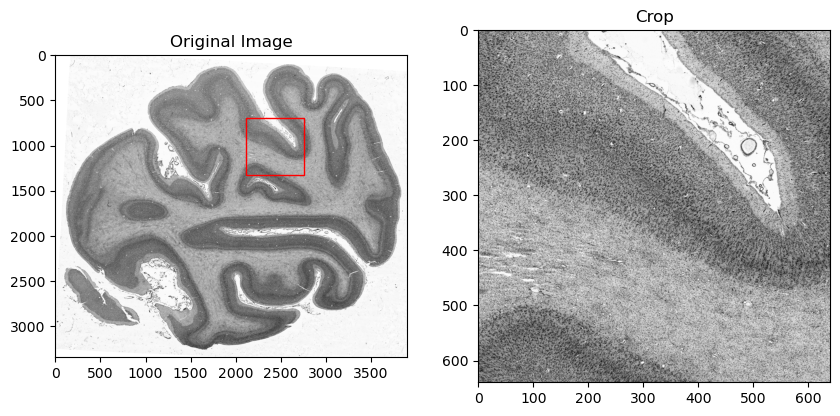

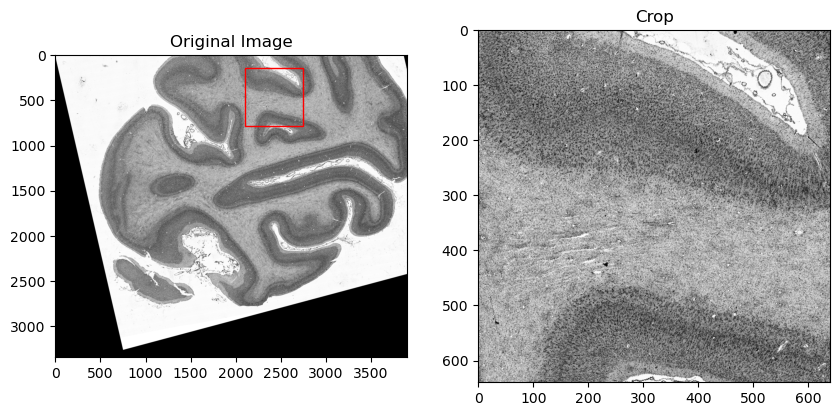

In [14]:
image_1_crop = crop_image(
    image=image_1, crop_position=crop_position_image_1, crop_size=crop_size
)
image_2_crop = crop_image(
    image=image_2, crop_position=crop_position_image_2, crop_size=crop_size
)
plot_image_with_crop(
    original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1
)
plot_image_with_crop(
    original_image=image_2, crop_image=image_2_crop, crop_position=crop_position_image_2
)

In [15]:
from source.data_processing.cropping import create_crop_coordinate_mapping

crop_coordinate_mapping = create_crop_coordinate_mapping(
    image_coordinate_mapping=image_coordinate_mapping,
    crop_position_image_1=crop_position_image_1,
    crop_position_image_2=crop_position_image_2,
    crop_size=crop_size,
)

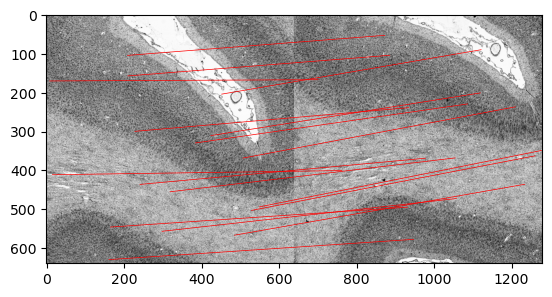

In [16]:
plot_images_with_matches_via_mapping(
    image_1_crop,
    image_2_crop,
    crop_coordinate_mapping,
    number_of_matches=20,
    sample_keypoints_randomly=True,
)

In [17]:
from source.data_processing.patch_processing import create_match_matrix

In [18]:
match_matrix = create_match_matrix(
    crop_coordinate_mapping, crop_size=640, patch_size=16
)

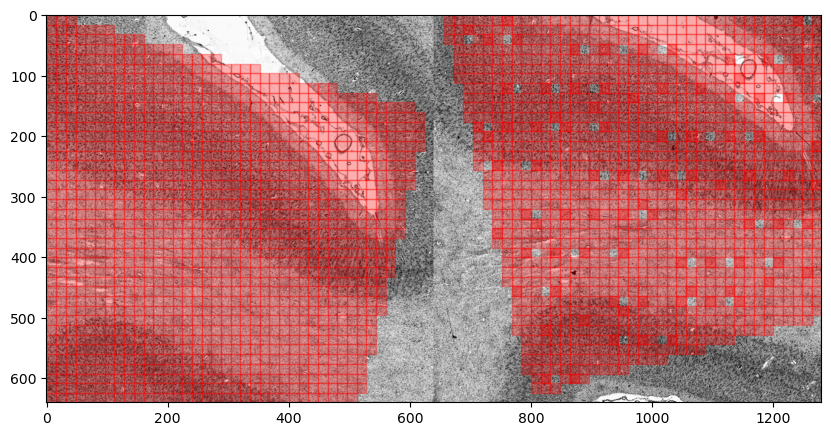

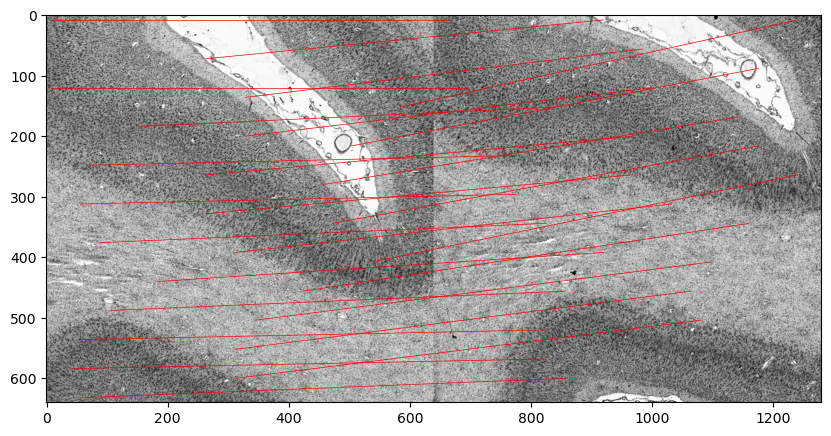

In [19]:
plot_images_with_matches_via_match_matrix(
    image_1_crop, image_2_crop, match_matrix, "patches"
)
plot_images_with_matches_via_match_matrix(
    image_1_crop, image_2_crop, match_matrix, "lines"
)

In [20]:
def translate_coarse_to_fine(
    coarse_coords: torch.Tensor, coarse_size: int, fine_size: int
) -> torch.Tensor:
    """
    Translates coordinates from a coarse feature map to a fine feature map.

    Args:
        coarse_coords (torch.Tensor): A tensor of shape (N, 2) representing coordinates in the coarse map.
        coarse_size (int): The size (height/width assuming square) of the coarse feature map.
        fine_size (int): The size (height/width assuming square) of the fine feature map.

    Returns:
        torch.Tensor: Translated coordinates in the fine feature map.
    """

    scale_factor = fine_size / coarse_size
    fine_coords = coarse_coords.float() * scale_factor

    return fine_coords.long()

In [21]:
translate_coarse_to_fine(torch.Tensor([[16, 32]]), coarse_size=40, fine_size=160)

tensor([[ 64, 128]])

In [22]:
translate_coarse_to_fine(torch.Tensor([[68, 132]]), coarse_size=160, fine_size=640)

tensor([[272, 528]])

In [23]:
from kornia.geometry.subpix import dsnt

In [24]:
dsnt.spatial_expectation2d(
    torch.Tensor(
        [
            [
                [
                    [0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0],
                ]
            ]
        ]
    )
)

tensor([[[ 1., -1.]]])

In [25]:
def translate_fine_to_coarse(
    fine_coords: torch.Tensor, fine_size: int, coarse_size: int
) -> torch.Tensor:
    """
    Translates coordinates from a fine feature map to a coarse feature map.

    Args:
        fine_coords (torch.Tensor): A tensor of shape (N, 2) representing coordinates in the fine map.
        fine_size (int): The size (height/width assuming square) of the fine feature map.
        coarse_size (int): The size (height/width assuming square) of the coarse feature map.

    Returns:
        torch.Tensor: Translated coordinates in the coarse feature map.
    """

    scale_factor = fine_size / coarse_size
    coarse_coords = fine_coords.float() / scale_factor

    return coarse_coords.long()

In [26]:
translate_fine_to_coarse(torch.Tensor([11, 11]), 640, 160)

tensor([2, 2])

Example for refinement supervision:

In [27]:
from source.data_processing.patch_processing import get_patch_index

In [28]:
get_patch_index(torch.Tensor([[0.0, 120.0]]))

tensor([280.])

In [29]:
def get_patch_coordinates(
    patch_indices: torch.Tensor, patch_size: int = 16, num_patches_per_side: int = 40
) -> torch.Tensor:
    """
    Calculates the top-left coordinates of patches in the image grid from their flattened grid indices.

    Args:
        patch_indices (torch.Tensor): A tensor containing the indices of patches in the flattened grid. Shape: (N,).
        patch_size (int): The size of each square patch.
        num_patches_per_side (int): The number of patches per side of the image grid. Defaults to 40.

    Returns:
        torch.Tensor: The top-left coordinates of the patches corresponding to the given indices. Shape: (N, 2).
    """

    # Calculate x and y coordinates
    x_coords = (patch_indices % num_patches_per_side) * patch_size
    y_coords = (patch_indices // num_patches_per_side) * patch_size

    # Combine x and y coordinates
    coordinates = torch.stack((x_coords, y_coords), dim=1)

    return coordinates

In [30]:
patch_index_crop_1, patch_index_crop_2 = match_matrix.nonzero()[
    123
]  # Some random nonzero element

In [31]:
patch_index_crop_1

tensor(303)

In [32]:
get_patch_coordinates(
    patch_index_crop_1.unsqueeze(0)
)  # Top left corner of chosen patch in crop 1

tensor([[368, 112]])

In [33]:
chosen_pixel_crop_1 = (
    get_patch_coordinates(patch_index_crop_1.unsqueeze(0))
    + torch.Tensor([[8, 8]]).long()
)  # The mid point of the patch
chosen_pixel_crop_1  # x,y

tensor([[376, 120]])

In [34]:
chosen_pixel_crop_2 = crop_coordinate_mapping[
    chosen_pixel_crop_1[0, 1], chosen_pixel_crop_1[0, 0]
]  # Where chosen pixel is in transformed crop
chosen_pixel_crop_2

tensor([392.1262,  26.2747])

In [35]:
# Double check if the patch index is correct (we know from patch_index_crop_2)
get_patch_index(
    coordinates=chosen_pixel_crop_2.unsqueeze(0), patch_size=16, num_patches_per_side=40
) == patch_index_crop_2

tensor([True])

In [36]:
chosen_pixel_crop_2_fine = translate_fine_to_coarse(
    chosen_pixel_crop_2, coarse_size=160, fine_size=640
)  # Fine level feature position in transformed crop
chosen_pixel_crop_2_fine

tensor([98,  6])

In [37]:
# Double check if we can reproduce pixel in orginal crop from chosen_pixel_crop_2_fine
translate_coarse_to_fine(
    chosen_pixel_crop_2_fine, coarse_size=160, fine_size=640
), chosen_pixel_crop_2

(tensor([392,  24]), tensor([392.1262,  26.2747]))

At this point it is clear how to get a fine feature of a patch matched in match matrix.
The next steps:

- Given the index of a matched patch in crop_1: Translate the mid pixel of this patch to fine-feature coordinates
- Do the same for crop_2
    - --> This gives the mid points of the local window for the refinement step

- For Supervision: 
    - Take the mid pixel of the patch in crop_1 and find out where it was transformed using the mapping
    - This returns coordinates in crop_2
    - Translate this coordinates to fine-features. This is different to the mid of the local window we computed before
    - Compute the relative coordinate of this fine feature wrt the local window. Note that the we already computed the mid point of this local window

In [38]:
# Get matched patches in crop 1 and crop 2
crop_1_patch_indices = match_matrix.nonzero()[:, 0]  # Get all patch indices in crop 1
crop_2_patch_indices = match_matrix.nonzero()[:, 1]  # Get all patch indices in crop 2

In [39]:
# Get mid point of patches in crop 1 and crop 2
crop_1_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_1_patch_indices)
    + torch.Tensor([8, 8]).long()
)  # Get all patch coordinates in crop 1 and add 8 to get the mid point of the patch
crop_2_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_2_patch_indices)
    + torch.Tensor([8, 8]).long()
)  # Get all patch coordinates in crop 2 and add 8 to get the mid point of the patch

In [43]:
crop_1_patch_indices.shape, crop_1_patch_mid_indices.shape

(torch.Size([1279]), torch.Size([1279, 2]))

In [44]:
# Translate the mid points of patches in crop 1 and 2 to the fine level
crop_1_patch_mid_indices_fine = translate_fine_to_coarse(
    crop_1_patch_mid_indices, coarse_size=160, fine_size=640
)
crop_2_patch_mid_indices_fine = translate_fine_to_coarse(
    crop_2_patch_mid_indices, coarse_size=160, fine_size=640
)

In [90]:
# Before we computed the mid point of the patches in crop 1 and 2.
# This block computes where the mid point of crop 1 went exactly in crop 2 through the affine transformation.
crop_1_mid_pixels_transformation = crop_coordinate_mapping[
    crop_1_patch_mid_indices[:, 1], crop_1_patch_mid_indices[:, 0]
]
crop_1_mid_pixels_transformation_fine = translate_fine_to_coarse(
    crop_1_mid_pixels_transformation, coarse_size=160, fine_size=640
)

In [91]:
# This difference is what we try to learn
crop_2_patch_mid_indices_fine, crop_1_mid_pixels_transformation_fine

(tensor([[ 14,  14],
         [ 14,  14],
         [ 18,  14],
         ...,
         [  6, 158],
         [ 10, 158],
         [ 14, 158]]),
 tensor([[ 12,  13],
         [ 15,  13],
         [ 18,  13],
         ...,
         [  6, 159],
         [  9, 159],
         [ 12, 159]]))

In [115]:
def get_relative_coordinates(
    transformed_coordinates: torch.Tensor,
    reference_coordinates: torch.Tensor,
    window_size: int = 5,
) -> torch.Tensor:
    """
    Converts absolute coordinates to relative coordinates within a local window.

    Args:
        transformed_coordinates (torch.Tensor): Transformed coordinates in, eg, the fine feature space.
        reference_coordinates (torch.Tensor): Reference coordinates, typically the mid-pixels of patches in crop_2.
        window_size (int): The size of the local window. Defaults to 5.

    Returns:
        torch.Tensor: Relative coordinates within the local window.
    """

    # Calculate the offset
    offset = transformed_coordinates - reference_coordinates

    # Normalize the offset to the -1 to 1 range
    relative_coordinates = offset / ((window_size - 1) / 2)

    return relative_coordinates

In [121]:
crop_1_mid_pixels_transformation_fine, crop_2_patch_mid_indices_fine

(tensor([[ 12,  13],
         [ 15,  13],
         [ 18,  13],
         ...,
         [  6, 159],
         [  9, 159],
         [ 12, 159]]),
 tensor([[ 14,  14],
         [ 14,  14],
         [ 18,  14],
         ...,
         [  6, 158],
         [ 10, 158],
         [ 14, 158]]))

In [123]:
relative_coordinates = get_relative_coordinates(
    transformed_coordinates=crop_1_mid_pixels_transformation_fine,
    reference_coordinates=crop_2_patch_mid_indices_fine,
)
relative_coordinates

tensor([[-1.0000, -0.5000],
        [ 0.5000, -0.5000],
        [ 0.0000, -0.5000],
        ...,
        [ 0.0000,  0.5000],
        [-0.5000,  0.5000],
        [-1.0000,  0.5000]])

In [120]:
# Relative coordinates cant be 1 since window_size = 5 where one 16x16 patch is only represented by 4x4 fine features.
# But because window_size must be odd we must stick to 5x5 windows.
(
    get_relative_coordinates(
        transformed_coordinates=crop_1_mid_pixels_transformation_fine,
        reference_coordinates=crop_2_patch_mid_indices_fine,
    )
    == 1
).sum()

tensor(0)

|          |         |       |         |        |
|----------|---------|-------|---------|--------|
| -1, -1   | -0.5, -1| 0, -1 | 0.5, -1 | 1, -1  |
| -1, -0.5 | -0.5,-0.5| 0, -0.5| 0.5, -0.5| 1, -0.5|
| -1, 0    | -0.5, 0 | 0, 0  | 0.5, 0  | 1, 0   |
| -1, 0.5  | -0.5, 0.5| 0, 0.5| 0.5, 0.5| 1, 0.5 |
| -1, 1    | -0.5, 1 | 0, 1  | 0.5, 1  | 1, 1   |


Reproduce image coordinates given the relative coordinate (that the model predicts) and the crop_2_patch_mid_indices_fine that we get from the match_matrix

In [130]:
crop_2_patch_mid_indices_fine, relative_coordinates

(tensor([[ 14,  14],
         [ 14,  14],
         [ 18,  14],
         ...,
         [  6, 158],
         [ 10, 158],
         [ 14, 158]]),
 tensor([[-1.0000, -0.5000],
         [ 0.5000, -0.5000],
         [ 0.0000, -0.5000],
         ...,
         [ 0.0000,  0.5000],
         [-0.5000,  0.5000],
         [-1.0000,  0.5000]]))

In [142]:
window_size = 5
crop_2_patch_mid_indices_fine + (relative_coordinates * ((window_size - 1) / 2))

tensor([[ 12.,  13.],
        [ 15.,  13.],
        [ 18.,  13.],
        ...,
        [  6., 159.],
        [  9., 159.],
        [ 12., 159.]])

In [143]:
translate_coarse_to_fine(
    crop_2_patch_mid_indices_fine + (relative_coordinates * ((window_size - 1) / 2)),
    coarse_size=160,
    fine_size=640,
)

tensor([[ 48,  52],
        [ 60,  52],
        [ 72,  52],
        ...,
        [ 24, 636],
        [ 36, 636],
        [ 48, 636]])

In [147]:
translate_coarse_to_fine(crop_1_mid_pixels_transformation_fine, 160, 640)

tensor([[ 48,  52],
        [ 60,  52],
        [ 72,  52],
        ...,
        [ 24, 636],
        [ 36, 636],
        [ 48, 636]])

In [149]:
crop_1_mid_pixels_transformation

tensor([[ 48.9456,  54.5717],
        [ 60.9022,  54.8444],
        [ 72.8589,  55.1171],
        ...,
        [ 24.8159, 639.4362],
        [ 36.7726, 639.7089],
        [ 48.7292, 639.9816]])

In [1]:
from kornia.utils.grid import create_meshgrid

In [2]:
grid_normalized = create_meshgrid(5, 5, True).reshape(1, -1, 2)  # [1, WW, 2]
grid_normalized

tensor([[[-1.0000, -1.0000],
         [-0.5000, -1.0000],
         [ 0.0000, -1.0000],
         [ 0.5000, -1.0000],
         [ 1.0000, -1.0000],
         [-1.0000, -0.5000],
         [-0.5000, -0.5000],
         [ 0.0000, -0.5000],
         [ 0.5000, -0.5000],
         [ 1.0000, -0.5000],
         [-1.0000,  0.0000],
         [-0.5000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.5000,  0.0000],
         [ 1.0000,  0.0000],
         [-1.0000,  0.5000],
         [-0.5000,  0.5000],
         [ 0.0000,  0.5000],
         [ 0.5000,  0.5000],
         [ 1.0000,  0.5000],
         [-1.0000,  1.0000],
         [-0.5000,  1.0000],
         [ 0.0000,  1.0000],
         [ 0.5000,  1.0000],
         [ 1.0000,  1.0000]]])